# Day 4: Model Optimization Techniques


**Objective:**  
Apply model optimization techniques to improve performance of a neural network trained on the Fashion-MNIST dataset. Explore hyperparameter tuning, compression methods, and deployment considerations.



### Load Dataset
**Fashion-MNIST Dataset**:  
- 60,000 training images  
- 10,000 test images  
- 10 categories (e.g., t-shirt, trouser, sneaker, bag)
- Normalize pixel values to [0,1], reshape to (28,28,1) and one-hot encode labels.


In [2]:

from tensorflow.keras.datasets import fashion_mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 2. Normalize pixel values (scale between 0 and 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


## Baseline CNN
A simple CNN with two Conv2D+MaxPool blocks and a Dense classifier. We train and record baseline accuracy and training time.


In [3]:

from tensorflow.keras import models, layers

def build_baseline_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

baseline_model = build_baseline_model()
baseline_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_baseline = baseline_model.fit(x_train, y_train, epochs=5, validation_split=0.1)
baseline_eval = baseline_model.evaluate(x_test, y_test)
baseline_eval


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.7748 - loss: 0.6195 - val_accuracy: 0.8822 - val_loss: 0.3331
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8902 - loss: 0.3029 - val_accuracy: 0.8985 - val_loss: 0.2747
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9073 - loss: 0.2566 - val_accuracy: 0.8937 - val_loss: 0.2763
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.9173 - loss: 0.2200 - val_accuracy: 0.9062 - val_loss: 0.2615
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9280 - loss: 0.1941 - val_accuracy: 0.9135 - val_loss: 0.2361
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9057 - loss: 0.2675


[0.2610622048377991, 0.9064000248908997]

## Model Compression
Apply dropout (already in the baseline) and use TensorFlow Model Optimization Toolkit for weight pruning to reduce model size. Compare performance.

In [8]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
from tensorflow.keras import models, layers
import tensorflow_model_optimization as tfmot

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=1000)
}

# Build normal model first:
def build_baseline_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Then prune the whole model:
model = build_baseline_model()
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)


In [13]:

# Convert baseline model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(baseline_model)
tflite_model = converter.convert()

# Save model
with open("baseline_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Baseline model size (KB):", len(tflite_model) / 1024)


Saved artifact at '/tmp/tmphpqwahyv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138021174317456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174319184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174316688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174317648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174320336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174319568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174320720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138021174320528: TensorSpec(shape=(), dtype=tf.resource, name=None)
Baseline model size (KB): 882.359375


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


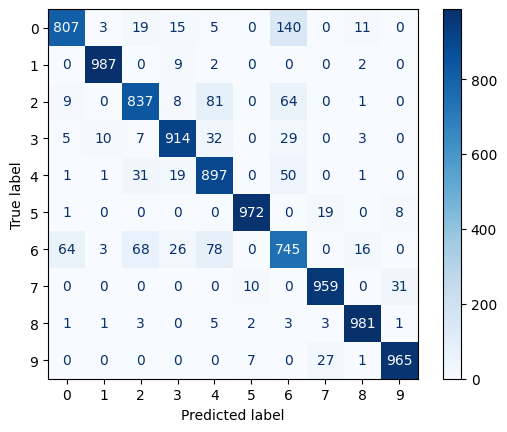

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = baseline_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()
